# kNN has 600x SPEEDUP! using GPU with RAPIDS cuML!

This notebook is a slightly adapted version of a [Kaggle notebook][2] by Chris Deotte.

In order to predict one test image in Kaggle's MNIST competition using kNN, we must multiply the test image which is a vector of length 784 by all 42,000 training vectors (of length 784) in the training set. This is 33 million multiplies. To predict all test images, we must do this for all 28,000 test images for a total of 1 trillion multiplies! 

A 3GHz single core CPU does 3 billion multiplies per second and therefore takes 300 seconds or 5 minutes to infer all test images. In comparison, a GPU with 1500 CUDA cores operating at 1.5GHz can do 2.2 trillion multiplies per second and therefore takes 0.5 seconds to infer all the test images. That's 750 times faster!
  
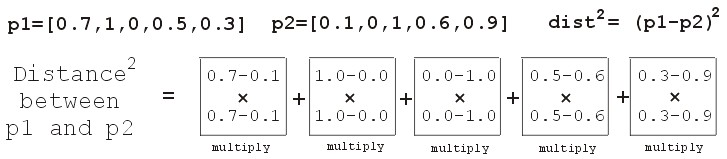
  
In this kernel, we show how RAPIDS cuML's kNN utilizes an Nvidia GPU to infer all test images in a sub-second time frame. For comparision, Scikit-learn's kNN uses CPUs. YMMV, but one routinely witnesses a 600x speedup using RAPIDS cuML!

You can learn more about Nvidia's RAPIDS library [here][1]. The RAPIDS library allows us to perform all our data science on GPUs. The library cuDF provides Pandas functionality on GPU, and cuML provides Scikit-learn functionality on GPU. Other libraries like cuGraph, cuSignal, cuSpatial provide additional machine learning tools.

[1]: https://rapids.ai/
[2]: https://www.kaggle.com/cdeotte/rapids-gpu-knn-mnist-0-97/notebook

In [ ]:
# LOAD LIBRARIES
import cudf, cuml
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split, KFold
from cuml.neighbors import KNeighborsClassifier, NearestNeighbors
import matplotlib.pyplot as plt
print('cuML version',cuml.__version__)

# Load Data

In [ ]:
!if [ ! -f test.csv ]; then unzip test.csv.zip;fi
!if [ ! -f train.csv ]; then unzip train.csv.zip;fi

In [ ]:
# LOAD TRAINING DATA
train = cudf.read_csv('train.csv')
print('train shape =', train.shape )
train.head()

In [ ]:
# VISUALIZE DATA
samples = train.iloc[5000:5030,1:].to_pandas().values
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(samples[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

# Grid Search kNN for optimal k
Here we perform grid search with a 20% holdout set to find the best parameter `k`. Alternatively, we could use full KFold cross validation shown below. We find that `k=3` achieves the best validation accuracy.

In [ ]:
# CREATE 20% VALIDATION SET
X_train, X_test, y_train, y_test = train_test_split(train.iloc[:,1:], train.iloc[:,0],test_size=0.2, random_state=42)
     

In [ ]:
X_train.shape

In [ ]:
# GRID SEARCH FOR OPTIMAL K
accs = []
for k in range(2,22):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    # Better to use knn.predict() but cuML v0.11.0 has bug
#    y_hat = knn.predict(X_test)
    y_hat_p = knn.predict_proba(X_test)
    acc = (y_hat_p.to_pandas().values.argmax(axis=1)==y_test.to_array() ).sum()/y_test.shape[0]
#    acc = (y_hat.to_pandas().values.argmax(axis=1)==y_test.to_array() ).sum()/y_test.shape[0]
    #print(k,acc)
    print(k,', ',acc ,end='')
    accs.append(acc)

In [ ]:
# COMPUTE NEIGHBORS
row = 5; col = 7; sft = 10
knn = NearestNeighbors(n_neighbors=col)
knn.fit(X_train)
distances, indicies = knn.kneighbors(X_test)
# DISPLAY NEIGHBORS
displayV = X_test.to_pandas().iloc[sft:row+sft].values
displayT = X_train.to_pandas().iloc[indicies[sft:row+sft].to_pandas().values.flatten()].values
plt.figure(figsize=(15,row*1.5))
for i in range(row):
    plt.subplot(row,col+1,(col+1)*i+1)
    plt.imshow(displayV[i].reshape((28,28)),cmap=plt.cm.binary)
    if i==0: plt.title('Unknown\nDigit')
    for j in range(col):
        plt.subplot(row, col+1, (col+1)*i+j+2)
        plt.imshow(displayT[col*i+j].reshape((28,28)),cmap=plt.cm.binary)
        if i==0: plt.title('Known\nNeighbor '+str(j+1))
        plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [ ]:
# PLOT GRID SEARCH RESULTS
plt.figure(figsize=(15,5))
plt.plot(range(2,22),accs)
plt.title('MNIST kNN k value versus validation acc')
plt.show()

# KFold Grid Search
For a more accurate grid search we could use KFold instead of a single holdout set. If we do this, we find it gives similar results as above.

In [ ]:
%%time
# GRID SEARCH USING CROSS VALIDATION
for k in range(2,22):
    print('k =',k)
    oof = np.zeros(len(train))
    skf = KFold(n_splits=5, shuffle=True, random_state=42)
    for i, (idxT, idxV) in enumerate( skf.split(train.iloc[:,1:], train.iloc[:,0]) ):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(train.iloc[idxT,1:], train.iloc[idxT,0])
        # Better to use knn.predict() but cuML v0.11.0 has bug
        # y_hat = knn.predict(train.iloc[idxV,1:])
        y_hat_p = knn.predict_proba(train.iloc[idxV,1:])
        oof[idxV] =  y_hat_p.to_pandas().values.argmax(axis=1)
        acc = ( oof[idxV]==train.iloc[idxV,0].to_array() ).sum()/len(idxV)
        print(' fold =',i,'acc =',acc)
    acc = ( oof==train.iloc[:,0].to_array() ).sum()/len(train)
    print(' OOF with k =',k,'ACC =',acc)

# Predict Test
Below we witness GPU RAPIDS kNN infer the entire Kaggle test dataset of 28,000 images against a training set of 48,000 images in an incredible 2.5 seconds (using Kaggle's Nvidia Tesla P100)! For comparison, a CPU (Intel Xeon 2 core) takes 600 times longer!

In [ ]:
# LOAD TEST DATA
test = cudf.read_csv('test.csv')
print('test shape =', test.shape )
test.head()

In [ ]:
# FIT KNN MODEL
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train.iloc[:,1:785], train.iloc[:,0])

In [ ]:
%%time
# PREDICT TEST DATA 100 TIMES for better measurement accuracy
for i in range(1,100):
  y_hat = knn.predict(test)

# Comparison to CPU kNN
For comparison, let us run inference on 16 CPU cores using sklearn.

In [ ]:
N_CORES = 16
# TRAIN SKLEARN KNN MODEL
from sklearn.neighbors import KNeighborsClassifier as K2
knn_cpu = K2(n_neighbors=3,n_jobs=N_CORES)
knn_cpu.fit(train.iloc[:,1:].to_pandas(), train.iloc[:,0].to_pandas())

In [ ]:
%%time
# PREDICT ALL TEST IMAGES WITH CPU
y_hat = knn_cpu.predict(test.to_pandas())